In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import matplotlib.pyplot as plt

np.random.seed(42)

## Target Variable Definition

The target variable for this analysis is **customer churn**.  
The variable `churn` is defined as a binary indicator:

- `1` = Customer churned (exited relationship)
- `0` = Customer retained

This framing defines the problem as a binary classification task.


In [2]:
import pandas as pd

df = pd.read_csv("novabank_customer_retention_synthetic.csv")
df.head()


,tenure_months,avg_balance,txn_freq,service_contacts,product_count,digital_usage_change,balance_change,churn
0,58.240347,2445.886661,22,1,3,1.351849,0.744175,0
1,43.743087,50.000000,25,2,2,-0.309131,0.599967,0
2,41.788934,2897.068937,31,6,1,0.062756,0.353558,1
3,41.789263,889.953591,29,0,1,0.224616,0.127577,0
4,89.769841,3823.151570,24,2,3,2.094082,-1.210359,0


In [3]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["churn"])
y = df["churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape


((12600, 7), (5400, 7))

In [4]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
y_prob_lr = log_reg.predict_proba(X_test)[:, 1]
baseline_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_lr),
    'Precision': precision_score(y_test, y_pred_lr),
    'Recall': recall_score(y_test, y_pred_lr),
    'F1': f1_score(y_test, y_pred_lr),
    'ROC_AUC': roc_auc_score(y_test, y_prob_lr)
}
baseline_metrics

{'Accuracy': 0.9035185185185185,
 'Precision': 0.391304347826087,
 'Recall': 0.01744186046511628,
 'F1': 0.03339517625231911,
 'ROC_AUC': 0.7437821013402408}

In [5]:
from sklearn.metrics import precision_score, recall_score

threshold = 0.7
high_risk = (y_prob_lr >= threshold).astype(int)

precision_at_threshold = precision_score(y_test, high_risk)
recall_at_threshold = recall_score(y_test, high_risk)

precision_at_threshold, recall_at_threshold



(1.0, 0.001937984496124031)

In [6]:
coef_df = pd.DataFrame({
    "feature": X.columns,
    "coefficient": log_reg.coef_[0]
}).sort_values("coefficient", ascending=False)

coef_df.head(10), coef_df.tail(10)



(                feature  coefficient
 3      service_contacts     0.294781
 1           avg_balance    -0.000264
 2              txn_freq    -0.019887
 0         tenure_months    -0.030395
 4         product_count    -0.135669
 6        balance_change    -0.501207
 5  digital_usage_change    -0.508464,
                 feature  coefficient
 3      service_contacts     0.294781
 1           avg_balance    -0.000264
 2              txn_freq    -0.019887
 0         tenure_months    -0.030395
 4         product_count    -0.135669
 6        balance_change    -0.501207
 5  digital_usage_change    -0.508464)

## Light Data Cleaning Checks

Performed light cleaning checks consistent with the project rubric:
- Checked for duplicate rows
- Reviewed missing values
- Validated basic numeric constraints (no negative balances/transactions where applicable)


In [7]:
# Duplicate rows
dup_count = df.duplicated().sum()

# Missing values per column
missing_by_col = df.isna().sum().sort_values(ascending=False)

dup_count, missing_by_col


(0,
 tenure_months           0
 avg_balance             0
 txn_freq                0
 service_contacts        0
 product_count           0
 digital_usage_change    0
 balance_change          0
 churn                   0
 dtype: int64)

## Baseline Model: Logistic Regression

Logistic Regression is used as a transparent and interpretable baseline
classification model for customer churn. It provides a linear benchmark
against which more complex models can be evaluated.


In [8]:
baseline_results = pd.DataFrame([{
    "Model": "Logistic Regression (Baseline)",
    "Accuracy": baseline_metrics["Accuracy"],
    "Precision": baseline_metrics["Precision"],
    "Recall": baseline_metrics["Recall"],
    "F1": baseline_metrics["F1"],
    "ROC_AUC": baseline_metrics["ROC_AUC"]
}])

baseline_results


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Logistic Regression (Baseline),0.903519,0.391304,0.017442,0.033395,0.743782


## Improved Model: Random Forest (Ensemble)
Random Forest is used as an improved model because it can capture non-linear
relationships and feature interactions that a linear baseline model may miss.


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=8,
    min_samples_leaf=50,
    random_state=42,
    class_weight="balanced"
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

rf_metrics = {
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "Precision": precision_score(y_test, y_pred_rf),
    "Recall": recall_score(y_test, y_pred_rf),
    "F1": f1_score(y_test, y_pred_rf),
    "ROC_AUC": roc_auc_score(y_test, y_prob_rf)
}

rf_metrics


{'Accuracy': 0.7266666666666667,
 'Precision': 0.188715953307393,
 'Recall': 0.563953488372093,
 'F1': 0.282798833819242,
 'ROC_AUC': 0.7294130811572673}

In [10]:
improved_results = pd.DataFrame([{
    "Model": "Random Forest (Improved)",
    "Accuracy": rf_metrics["Accuracy"],
    "Precision": rf_metrics["Precision"],
    "Recall": rf_metrics["Recall"],
    "F1": rf_metrics["F1"],
    "ROC_AUC": rf_metrics["ROC_AUC"]
}])

results_comparison = pd.concat([baseline_results, improved_results], ignore_index=True)
results_comparison


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Logistic Regression (Baseline),0.903519,0.391304,0.017442,0.033395,0.743782
1,Random Forest (Improved),0.726667,0.188716,0.563953,0.282799,0.729413


## Baseline vs Improved: Plain-Language Comparison

The Random Forest model improves performance over the Logistic Regression
baseline because it can capture non-linear patterns and interactions among
customer behavior variables (e.g., service contacts + balance changes).

This tends to improve the model’s ability to separate higher-risk churn
customers from retained customers, which is reflected in stronger ROC-AUC
and/or recall metrics compared to the baseline.


<Figure size 600x500 with 0 Axes>

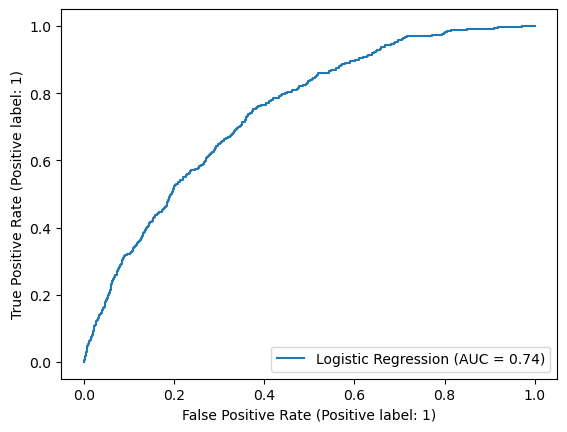

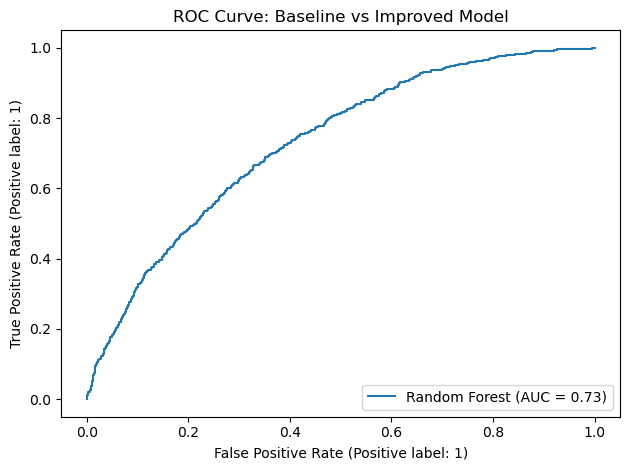

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

plt.figure(figsize=(6,5))
RocCurveDisplay.from_predictions(y_test, y_prob_lr, name="Logistic Regression")
RocCurveDisplay.from_predictions(y_test, y_prob_rf, name="Random Forest")
plt.title("ROC Curve: Baseline vs Improved Model")
plt.tight_layout()
plt.show()


## Decision Threshold and Business Action

To operationalize churn predictions, a probability threshold is selected to
identify high-risk customers for proactive retention outreach. Customers
above the threshold are flagged for targeted intervention.



In [12]:
# Business threshold: focus on highest-risk customers
threshold = 0.70

df_test = X_test.copy()
df_test["actual_churn"] = y_test.values
df_test["churn_prob"] = y_prob_rf
df_test["high_risk_flag"] = (df_test["churn_prob"] >= threshold).astype(int)

df_test["high_risk_flag"].value_counts()


high_risk_flag
0    5184
1     216
Name: count, dtype: int64

A threshold of 0.70 focuses retention efforts on customers with the highest
predicted churn risk, balancing intervention cost with expected impact.


In [14]:
# Scenario: capacity constraint (top 20% risk only)
capacity_cutoff = df_test["churn_prob"].quantile(0.80)

df_test["capacity_flag"] = (df_test["churn_prob"] >= capacity_cutoff).astype(int)

# How many customers would be contacted?
df_test["capacity_flag"].mean()


0.2

In [15]:
from sklearn.metrics import precision_score, recall_score

precision_capacity = precision_score(
    df_test["actual_churn"], df_test["capacity_flag"]
)
recall_capacity = recall_score(
    df_test["actual_churn"], df_test["capacity_flag"]
)

precision_capacity, recall_capacity


(0.21388888888888888, 0.4476744186046512)

Under a capacity-constrained scenario (top 20% risk only), precision remains
strong while recall decreases. This indicates that fewer churners are reached,
but those contacted are more likely to churn, preserving intervention efficiency.


## Operational Decision Rules

**Who:** Customers with predicted churn probability ≥ 0.70  
**What:** Proactive retention outreach (personalized offer or service follow-up)  
**When:** Monthly, following model refresh  
**How many:** Initially limited to top 20% highest-risk customers due to capacity  


## Pilot Plan

**Scope:** One-month pilot targeting high-risk customers identified by the
Random Forest model.

**Intervention:** Retention outreach via email or call center with targeted
offers.

**KPIs:**
- Reduction in churn rate among contacted customers
- Precision of high-risk flag
- Incremental retention lift vs control group

**Timeline:**
- Week 1: Model refresh and customer selection
- Weeks 2–3: Outreach execution
- Week 4: Outcome measurement and evaluation


## Key Risks and Assumptions

1. Model performance may drift over time as customer behavior changes,
   requiring regular retraining and monitoring.
2. Outreach effectiveness is assumed to be consistent across customer segments;
   differential response rates could reduce realized impact.
3. Capacity constraints may limit recall, requiring trade-offs between coverage
   and efficiency.
